# Build Your Own Model

One important feature of `orbit` is to allow developers to build their own models in a relatively flexible manner to serve their own purpose. This tutorial will go over a demo on how to build up a simple Bayesian linear regression model using [Pyro API](http://pyro.ai/) in the backend with orbit interface.

## Orbit Class Design

In version `1.1.0`, the classes within Orbit are re-designed as such:
    
1. Forecaster
2. Model
3. Estimator

### Forecaster

**Forecaster** provides general interface for users to perform `fit` and `predict` task. It is further inherited to provide different types of forecasting methodology: 

1. [Maximum a posterior \(MAP\)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)
2. [Stochastic Variational Inference \(SVI\)]
3. Full Bayesian

The discrepancy on these three methods mainly lie on the posteriors estimation where **MAP** will yield point posterior estimate and can be extracted through the method `get_point_posterior()`. Meanwhile, **SVI** and **Full Bayesian** allow posterior sample extraction through the method `get_posteriors()`.  Alternatively, you can also approximate point estimate by passing through additional arg such as `point_method='median'` in the `.fit()` process.

To make use of a **Forecaster**, one must provide these two objects:

1. Model
2. Estimator

Theses two objects are prototyped as abstract and next subsections will cover how they work.

### Model

**Model** is an object defined by a class inherited from `BaseTemplate` a.k.a **Model Template** in the diagram below.  It mainly turns the logic of `fit()` and `predict()` concrete by supplying the `fitter` as a file (**PyStan**) or a callable class (**Pyro**) and the internal `predict()` method. This object defines the overall inputs, model structure, parameters and likelihoods.

### Estimator

Meanwhile, there are different APIs implement slightly different ways of sampling and optimization (for **MAP**). `orbit` is designed to support various APIs such as **PyStan** and **Pyro** (hopefully PyMC3, Numpyro in the future!). The logic separating the call of different APIs with different interface is done by the **Estimator** class which is further inherited in `PyroEstimator` and `StanEstimator`.


![Orbit-Design](../img/orbit-v11-design.png)

Diagram above shows the interaction across classes under the Orbit package design.

## Creating a Bayesian Linear Regression Model

The plan here is to build a classical regression model with the formula below:
    
$$y = \alpha +  X \beta + \epsilon$$

where $\alpha$ is the intercept, $\beta$ is the coefficients matrix and $\epsilon$ is the random noise.

To start with let's load the libraries.

In [1]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from copy import deepcopy
import matplotlib.pyplot as plt

import orbit
from orbit.template.model_template import ModelTemplate
from orbit.forecaster import SVIForecaster
from orbit.estimators.pyro_estimator import PyroEstimatorSVI

from orbit.utils.simulation import make_regression
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

%matplotlib inline

/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(orbit.__version__)

1.1.4.2


Since the **Forecaster** and **Estimator** are already built inside `orbit`, the rest of the ingredients to construct a new model will be a **Model** object that contains the follow:

- a callable class as a fitter
- a predict method

### Define a Fitter

For **Pyro** users, you should find the code below familiar. All it does is to put a Bayesian linear regression (**BLR**) model code in a callable class.  Details of **BLR** will not be covered here.  Note that the parameters here need to be consistent .

In [3]:
class MyFitter:
    max_plate_nesting = 1  # max number of plates nested in model

    def __init__(self, data):
        for key, value in data.items():
            key = key.lower()
            if isinstance(value, (list, np.ndarray)):
                value = torch.tensor(value, dtype=torch.float)
            self.__dict__[key] = value

    def __call__(self):
        extra_out = {}
        
        p = self.regressor.shape[1]
        bias = pyro.sample("bias", dist.Normal(0, 1))
        weight = pyro.sample("weight", dist.Normal(0, 1).expand([p]).to_event(1))
        yhat = bias + weight @ self.regressor.transpose(-1, -2)
        obs_sigma = pyro.sample("obs_sigma", dist.HalfCauchy(self.response_sd))
        
        with pyro.plate("response_plate", self.num_of_obs):
            pyro.sample("response", dist.Normal(yhat, obs_sigma), obs=self.response)
            
        log_prob = dist.Normal(yhat[..., 1:], obs_sigma).log_prob(self.response[1:])
        extra_out.update(
            {"log_prob": log_prob}
        )
        
        return extra_out

### Define the Model Class

This is the part requires the knowledge of `orbit` most.  First we construct a class by plugging in the `fitter` callable. Users need to let the `orbit` estimators know the required input in addition to the defaults (e.g. `response`, `response_sd` etc.). In this case, it takes `regressor` as the matrix input from the data frame. That is why there are lines of code to provide this information in 

1. `_data_input_mapper` - a list or `Enum` to let estimator keep tracking required data input
2. `set_dynamic_attributes` - the logic define the actual inputs i.e. `regressor` from the data frame. This is a **reserved function** being called inside **Forecaster**.

Finally, we code the logic in `predict()` to define how we utilize posteriors to perform in-sample / out-of-sample prediction. Note that the output needs to be a dictionary where it supports **components decomposition**.

In [4]:
class BayesLinearRegression(ModelTemplate):
    _fitter = MyFitter
    _data_input_mapper = ['regressor']
    _supported_estimator_types = [PyroEstimatorSVI]
    
    def __init__(self, regressor_col, **kwargs):
        super().__init__(**kwargs)
        self.regressor_col = regressor_col
        self.regressor = None
        self._model_param_names = ['bias', 'weight', 'obs_sigma']
        
    def set_dynamic_attributes(self, df, training_meta):  
        self.regressor = df[self.regressor_col].values
    
    def predict(self, posterior_estimates, df, training_meta, prediction_meta, include_error=False, **kwargs):
        model = deepcopy(posterior_estimates)
        new_regressor = df[self.regressor_col].values.T
        bias =  np.expand_dims(model.get('bias'),-1)
        obs_sigma = np.expand_dims(model.get('obs_sigma'), -1)
        weight = model.get('weight')
        
        pred_len = df.shape[0]
        batch_size = weight.shape[0]
        
        prediction = bias + np.matmul(weight, new_regressor) + \
            np.random.normal(0, obs_sigma, size=(batch_size, pred_len))
        return {'prediction': prediction}

## Test the New Model with Forecaster

Once the model class is defined. User can initialize an object and build a forecaster for fit and predict purpose. Before doing that, the demo provides a simulated dataset here.

### Data Simulation

In [5]:
x, y, coefs = make_regression(120, [3.0, -1.0], bias=1.0, scale=1.0)

In [6]:
df = pd.DataFrame(
    np.concatenate([y.reshape(-1, 1), x], axis=1), columns=['y', 'x1', 'x2']
)
df['week'] = pd.date_range(start='2016-01-04', periods=len(y), freq='7D')

In [7]:
df.head(5)

,y,x1,x2,week
0,2.382337,0.345584,0.000000,2016-01-04
1,2.812929,0.330437,-0.000000,2016-01-11
2,3.600130,0.905356,0.446375,2016-01-18
3,-0.884275,-0.000000,0.581118,2016-01-25
4,2.704941,0.364572,0.294132,2016-02-01


In [8]:
test_size = 20
train_df = df[:-test_size]
test_df = df[-test_size:]

### Create the Forecaster

As mentioned previously, model is the inner object to control the math. To use it for fit and predict purpose, we need a **Forecaster**. Since the model is written in **Pyro**, the pick here should be `SVIForecaster`.

In [9]:
model = BayesLinearRegression(
    regressor_col=['x1','x2'], 
)

In [10]:
blr = SVIForecaster(
    model=model,
    response_col='y', 
    date_col='week',
    estimator_type=PyroEstimatorSVI,
    verbose=True,
    num_steps=501,
    seed=2021,
)

In [11]:
blr

Now, an object `blr` is instantiated as a `SVIForecaster` object and is ready for fit and predict.

In [12]:
blr.fit(train_df)

2023-12-25 15:20:13 - orbit - INFO - Using SVI (Pyro) with steps: 501, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-12-25 15:20:13 - orbit - INFO - step    0 loss = 27333, scale = 0.077497
INFO:orbit:step    0 loss = 27333, scale = 0.077497
2023-12-25 15:20:15 - orbit - INFO - step  100 loss = 12594, scale = 0.00924
INFO:orbit:step  100 loss = 12594, scale = 0.00924
2023-12-25 15:20:17 - orbit - INFO - step  200 loss = 12596, scale = 0.0094562
INFO:orbit:step  200 loss = 12596, scale = 0.0094562
2023-12-25 15:20:18 - orbit - INFO - step  300 loss = 12591, scale = 0.0092175
INFO:orbit:step  300 loss = 12591, scale = 0.0092175
2023-12-25 15:20:20 - orbit - INFO - step  400 loss = 12594, scale = 0.0095741
INFO:orbit:step  400 loss = 12594, scale = 0.0095741
2023-12-25 15:20:22 - orbit - INFO - step  500 loss = 12591, scale = 0.0095602
INFO:orbit:step  500 loss = 12591, scale = 0.0095602


### Compare Coefficients with Truth

In [13]:
estimated_weights = blr.get_posterior_samples()['weight']

The code below is to compare the median of coefficients posteriors which is labeled as `weight` with the truth.

In [14]:
print("True Coef: {:.3f}, {:.3f}".format(coefs[0], coefs[1]) )
estimated_coef = np.median(estimated_weights, axis=0)
print("Estimated Coef: {:.3f}, {:.3f}".format(estimated_coef[0], estimated_coef[1]))

True Coef: 3.000, -1.000
Estimated Coef: 2.964, -0.966


### Examine Forecast Accuracy

In [15]:
predicted_df = blr.predict(df)

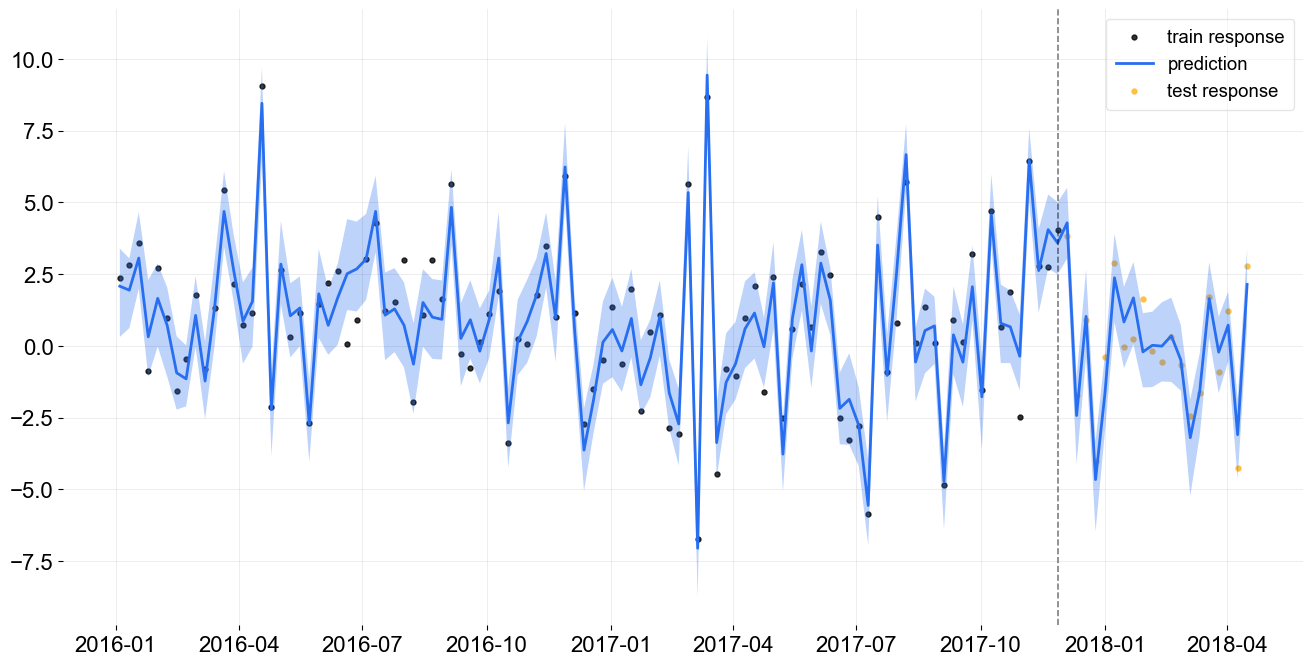

In [16]:
_ = plot_predicted_data(train_df, predicted_df, 'week', 'y', test_actual_df=test_df, prediction_percentiles=[5, 95])

### Additional Notes

In general, most of the **diagnostic tools** in orbit such as posteriors checking and plotting is applicable in the model created in this style.  Also, users can provide `point_method='median'` in the `fit()` under the **SVIForecaster** to extract median of posteriors directly.